<a href="https://colab.research.google.com/github/AbitathaRoy/Urban-AQI-Trends/blob/main/Workstation%206%20Mumbai%20(Borivalli%20East%20MPCB)/Mumbai_Borivalli_East_MPCB_Weather_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

## Import packages

In [ ]:
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install adaboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement adaboost (from versions: none)
ERROR: No matching distribution found for adaboost


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm, trange

In [ ]:
!git clone https://github.com/AbitathaRoy/Urban-AQI-Trends.git

Cloning into 'Urban-AQI-Trends'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 67 (delta 24), reused 52 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (67/67), 616.55 KiB | 6.29 MiB/s, done.
Resolving deltas: 100% (24/24), done.


## Setup Data

Initialise dataset

In [ ]:
# Borivalli East MPCB Mumbai
all_dfs = []
all_dfs.append(pd.read_csv("/content/Urban-AQI-Trends/Workstation 6 Mumbai (Borivalli East MPCB)/Raw_data_1Day_2019_site_5113_Borivali_East_Mumbai_MPCB_1Day.csv"))
all_dfs.append(pd.read_csv("/content/Urban-AQI-Trends/Workstation 6 Mumbai (Borivalli East MPCB)/Raw_data_1Day_2020_site_5113_Borivali_East_Mumbai_MPCB_1Day.csv"))
all_dfs.append(pd.read_csv("/content/Urban-AQI-Trends/Workstation 6 Mumbai (Borivalli East MPCB)/Raw_data_1Day_2021_site_5113_Borivali_East_Mumbai_MPCB_1Day.csv"))
all_dfs.append(pd.read_csv("/content/Urban-AQI-Trends/Workstation 6 Mumbai (Borivalli East MPCB)/Raw_data_1Day_2022_site_5113_Borivali_East_Mumbai_MPCB_1Day.csv"))
all_dfs.append(pd.read_csv("/content/Urban-AQI-Trends/Workstation 6 Mumbai (Borivalli East MPCB)/Raw_data_1Day_2024_site_5113_Borivali_East_Mumbai_MPCB_1Day.csv"))

df = pd.concat(all_dfs, ignore_index=True)

Exploratory Data Analysis and Data Wrangling

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1030 entries, 163 to 1811
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AQI                  1030 non-null   float64
 1   PM2.5 (µg/m³)        1030 non-null   float64
 2   PM10 (µg/m³)         1030 non-null   float64
 3   NO (µg/m³)           1030 non-null   float64
 4   NO2 (µg/m³)          1030 non-null   float64
 5   NOx (ppb)            1030 non-null   float64
 6   NH3 (µg/m³)          1030 non-null   float64
 7   SO2 (µg/m³)          1030 non-null   float64
 8   CO (mg/m³)           1030 non-null   float64
 9   Ozone (µg/m³)        1030 non-null   float64
 10  Benzene (µg/m³)      1030 non-null   float64
 11  Eth-Benzene (µg/m³)  1030 non-null   float64
 12  MP-Xylene (µg/m³)    1030 non-null   float64
 13  AT (°C)              1030 non-null   float64
 14  RH (%)               1030 non-null   float64
 15  WS (m/s)             1030 non-null   floa

In [ ]:
#Preprocessing Type 1

df.drop(columns=["O Xylene (µg/m³)", "Timestamp", "Xylene (µg/m³)", "RF (mm)"], inplace=True)

df["Benzene (µg/m³)"] = df["Benzene (µg/m³)"].fillna(df["Benzene (µg/m³)"].mean())
df["Toluene (µg/m³)"] = df["Toluene (µg/m³)"].fillna(df["Toluene (µg/m³)"].mean())
df["Eth-Benzene (µg/m³)"] = df["Eth-Benzene (µg/m³)"].fillna(df["Eth-Benzene (µg/m³)"].mean())
df["MP-Xylene (µg/m³)"] = df["MP-Xylene (µg/m³)"].fillna(df["MP-Xylene (µg/m³)"].mean())
df["BP (mmHg)"] = df["BP (mmHg)"].fillna(df["BP (mmHg)"].mean())

In [ ]:
#Preprocessing Type 2

df.drop(columns=["Toluene (µg/m³)", "O Xylene (µg/m³)", "Timestamp", "Xylene (µg/m³)", "RF (mm)", "VWS (m/s)"], inplace=True)
df.drop(columns=["SR (W/mt2)", "BP (mmHg)"], inplace=True)

KeyError: "['Toluene (µg/m³)', 'O Xylene (µg/m³)', 'Timestamp', 'Xylene (µg/m³)', 'RF (mm)', 'VWS (m/s)'] not found in axis"

In [ ]:
df.dropna(axis=0, inplace=True)

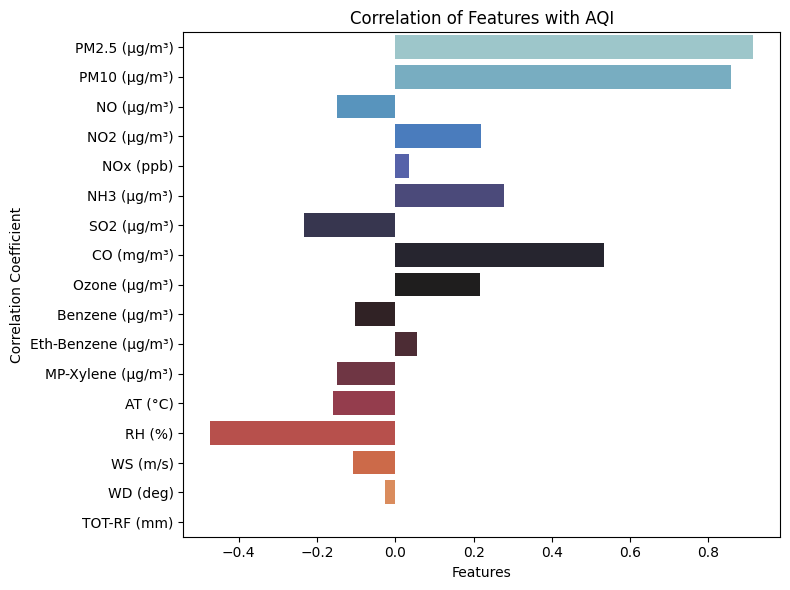

In [ ]:
correlation_matrix = df.corr()
correlation_array_aqi = correlation_matrix.loc["AQI"].drop(["AQI"])
# correlation_array_aqi = np.transpose(correlation_array_aqi)
# print(correlation_array_aqi.values)

plt.figure(figsize=(8, 6))
num_bars = len(correlation_array_aqi)
colors = sns.color_palette("icefire", n_colors=num_bars)
sns.barplot(x=correlation_array_aqi.values,
            y=correlation_array_aqi.index,
            hue=correlation_array_aqi.index,
            palette=colors,
            legend=False)
plt.title('Correlation of Features with AQI')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

Pipeline

In [ ]:
sorted_features = abs(correlation_array_aqi).sort_values(ascending=False)
sorted_features_list = sorted_features.index.tolist()

In [ ]:
def select_top_features(X, sorted_features_list, i):
  """
  Selects the top i features from the DataFrame X based on the sorted feature list.

  Args:
    X: The original feature DataFrame.
    sorted_features_list: A list of features sorted by correlation in descending order.
    i: The number of top features to select.

  Returns:
    A DataFrame containing the top i features.
  """
  top_features = sorted_features_list[:i]
  return X[top_features]

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

def evaluate_model(model, X_subset, y):
  """
  Evaluates a model using cross-validation and calculates R-squared, MSE, and MAE.

  Args:
    model: The machine learning model to evaluate.
    X_subset: The DataFrame containing the selected features.
    y: The target Series.

  Returns:
    A dictionary containing the mean R-squared, MSE, and MAE scores from cross-validation.
  """
  # Perform cross-validation
  r2_scores = cross_val_score(model, X_subset, y, scoring='r2', cv=5)
  mse_scores = cross_val_score(model, X_subset, y, scoring='neg_mean_squared_error', cv=5)
  mae_scores = cross_val_score(model, X_subset, y, scoring='neg_mean_absolute_error', cv=5)

  mse_scores = abs(mse_scores)
  mae_scores = abs(mae_scores)

  # Calculate mean scores
  mean_r2 = r2_scores.mean()
  mean_mse = mse_scores.mean()
  mean_mae = mae_scores.mean()

  return {
      'R-squared': mean_r2,
      'MSE': mean_mse,
      'MAE': mean_mae
  }

In [ ]:
def find_best_features_and_model(model, X_train, y_train, sorted_features_list):
  """
  Finds the best number of features for a given model based on evaluation metrics.

  Args:
    model: An initialized machine learning model.
    X_train: The training features DataFrame.
    y_train: The training target Series.
    sorted_features_list: A list of features sorted by correlation in descending order.

  Returns:
    A dictionary containing the best evaluation scores and the number of features used.
  """
  best_r2 = -float('inf')
  best_mse = float('inf')
  best_mae = float('inf')
  best_i = 0
  results = []

  for i in trange(1, len(sorted_features_list) + 1):
    # Select top i features
    X_subset = select_top_features(X_train, sorted_features_list, i)

    # Not required.
    model.fit(X_subset, y_train)

    # Evaluate the model with the selected features
    scores = evaluate_model(model, X_subset, y_train)
    results.append({'num_features': i, **scores})

    # Check for best performance based on R-squared (highest), then MSE (lowest), then MAE (lowest)
    if scores['R-squared'] > best_r2:
        best_r2 = scores['R-squared']
        best_mse = scores['MSE']
        best_mae = scores['MAE']
        best_i = i
    elif scores['R-squared'] == best_r2:
        if scores['MSE'] < best_mse:
            best_mse = scores['MSE']
            best_mae = scores['MAE']
            best_i = i
        elif scores['MSE'] == best_mse:
            if scores['MAE'] < best_mae:
                best_mae = scores['MAE']
                best_i = i

    # Add slider

  print()
  print("--Cross Validation Analysis--")
  print(f"Best performance with {best_i} features:")
  print(f"R-squared: {best_r2:.4f}")
  print(f"MSE: {best_mse:.4f}")
  print(f"MAE: {best_mae:.4f}")
  print(f"Features used: {sorted_features_list[:best_i]}")
  # print()

  return best_i

Training and Testing Sets

In [ ]:
y = df["AQI"]
X = df.drop(columns=["AQI"])

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X_standardized_wrapped = pd.DataFrame(
    X_standardized,
    columns=X.columns
)

X_train, X_test, y_train, y_test = train_test_split(X_standardized_wrapped, y, random_state=24, train_size=0.7)

Status

In [ ]:
print(f"Experiment running on {len(df)} unique daily entries from 2019 to 2022 and 2024.")

Experiment running on 1030 unique daily entries from 2019 to 2022 and 2024.


# Machine Learning Algorithms

Random Forest

In [ ]:
def random_forest():
  model = RandomForestRegressor(
      n_estimators=50,
      criterion='squared_error',
      max_depth=None,
      min_samples_split=2,
      min_samples_leaf=1,
      max_leaf_nodes=None,
      random_state=24,
      verbose=0,
      n_jobs=-1
  )

  cross_val_scores = cross_val_score(
      estimator=model,
      X=X_train,
      y=y_train,
      verbose=0,
      cv=5,
      n_jobs=-1
  )

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)

  print("-Random Forest-")
  print(f"Cross Validation Score = {round(cross_val_scores.mean(), 4)}")
  print(f"R^2 Score = {round(model.score(X_test, y_test), 4)}")
  print(f"MSE = {round(mse, 4)}")
  print(f"MAE = {round(mae, 4)}")

random_forest()

-Random Forest-
Cross Validation Score = 0.908
R^2 Score = 0.9013
MSE = 247.5536
MAE = 10.3055


Adaboost

In [ ]:
def adaboost():
  model = AdaBoostRegressor(
      n_estimators=100,
      learning_rate=0.05,
      loss='linear',
      random_state=24
  )

  cross_val_scores = cross_val_score(
      estimator=model,
      X=X_train,
      y=y_train,
      verbose=0,
      cv=5,
      n_jobs=-1
  )

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)

  print("-AdaBoost-")
  print(f"Cross Validation Score = {round(cross_val_scores.mean(), 4)}")
  print(f"R^2 Score = {round(model.score(X_test, y_test), 4)}")
  print(f"MSE = {round(mse, 4)}")
  print(f"MAE = {round(mae, 4)}")

adaboost()

-AdaBoost-
Cross Validation Score = 0.8921
R^2 Score = 0.8942
MSE = 265.4923
MAE = 11.2579


CatBoost

In [ ]:
def catboost():
  model = CatBoostRegressor(
      learning_rate=0.05,
      depth=None,
      loss_function='RMSE',
      verbose=0,
      n_estimators=500,
      early_stopping_rounds=50
  )

  cross_val_scores = cross_val_score(
      estimator=model,
      X=X_train,
      y=y_train,
      verbose=0,
      cv=5,
      n_jobs=-1
  )

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)

  print("-CatBoost-")
  print(f"Cross Validation Score = {round(cross_val_scores.mean(), 4)}")
  print(f"R^2 Score = {round(model.score(X_test, y_test), 4)}")
  print(f"MSE = {round(mse, 4)}")
  print(f"MAE = {round(mae, 4)}")

catboost()

-CatBoost-
Cross Validation Score = 0.9084
R^2 Score = 0.9122
MSE = 220.2486
MAE = 10.2545


XGBoost

In [ ]:
def xgboost():
  model = XGBRegressor(
      n_estimators=200,
      max_depth=None,
      learning_rate=0.05,
      n_jobs=-1
  )

  cross_val_scores = cross_val_score(
      estimator=model,
      X=X_train,
      y=y_train,
      verbose=0,
      cv=5,
      n_jobs=-1
  )

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)

  print("-XGBoost-")
  print(f"Cross Validation Score = {round(cross_val_scores.mean(), 4)}")
  print(f"R^2 Score = {round(model.score(X_test, y_test), 4)}")
  print(f"MSE = {round(mse, 4)}")
  print(f"MAE = {round(mae, 4)}")

xgboost()

-XGBoost-
Cross Validation Score = 0.9063
R^2 Score = 0.9045
MSE = 239.6883
MAE = 10.3028


LightGBM

In [ ]:
def lightgbm():
  model = LGBMRegressor(
      num_leaves=31,
      max_depth=-1,
      learning_rate=0.05,
      n_estimators=100,
      min_child_samples=1,
      random_state=24,
      n_jobs=-1,
      verbose=0
  )

  cross_val_scores = cross_val_score(
      estimator=model,
      X=X_train,
      y=y_train,
      verbose=0,
      cv=5,
      n_jobs=-1
  )

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)

  print("-LightGBM-")
  print(f"Cross Validation Score = {round(cross_val_scores.mean(), 4)}")
  print(f"R^2 Score = {round(model.score(X_test, y_test), 4)}")
  print(f"MSE = {round(mse, 4)}")
  print(f"MAE = {round(mae, 4)}")

lightgbm()

-LightGBM-
Cross Validation Score = 0.9084
R^2 Score = 0.9043
MSE = 240.2023
MAE = 10.1504


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# Machine Learning Algorithms using Pipeline

Random Forest

In [ ]:
model = RandomForestRegressor(
    n_estimators=50,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_leaf_nodes=None,
    random_state=24,
    verbose=0,
    n_jobs=-1
)

print("-Random Forest-")

# print("--Cross Validation Analysis--")
i = find_best_features_and_model(model, X_train, y_train, sorted_features_list)

# Extract optimum subset
X_train_subset = select_top_features(X_train, sorted_features_list, i)
X_test_subset = select_top_features(X_test, sorted_features_list, i)

print("--Model Analysis--")
model.fit(X_train_subset, y_train)
y_pred = model.predict(X_test_subset)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2 Score = {round(model.score(X_test_subset, y_test), 4)}")
print(f"MSE = {round(mse, 4)}")
print(f"MAE = {round(mae, 4)}")
print()

-Random Forest-


100%|██████████| 17/17 [00:56<00:00,  3.30s/it]



--Cross Validation Analysis--
Best performance with 6 features:
R-squared: 0.9197
MSE: 237.4584
MAE: 9.7892
Features used: ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'RH (%)', 'NH3 (µg/m³)', 'SO2 (µg/m³)']
--Model Analysis--
R^2 Score = 0.8776
MSE = 320.5411
MAE = 10.1854



Adaboost

In [ ]:
model = AdaBoostRegressor(
      n_estimators=100,
      learning_rate=0.05,
      loss='linear',
      random_state=24
)

print("-AdaBoost-")

# print("--Cross Validation Analysis--")
i = find_best_features_and_model(model, X_train, y_train, sorted_features_list)

# Extract optimum subset
X_train_subset = select_top_features(X_train, sorted_features_list, i)
X_test_subset = select_top_features(X_test, sorted_features_list, i)

print("--Model Analysis--")
model.fit(X_train_subset, y_train)
y_pred = model.predict(X_test_subset)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2 Score = {round(model.score(X_test_subset, y_test), 4)}")
print(f"MSE = {round(mse, 4)}")
print(f"MAE = {round(mae, 4)}")
print()

-AdaBoost-


100%|██████████| 17/17 [01:14<00:00,  4.39s/it]



--Cross Validation Analysis--
Best performance with 16 features:
R-squared: 0.9060
MSE: 275.7102
MAE: 11.5019
Features used: ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'RH (%)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'NO2 (µg/m³)', 'Ozone (µg/m³)', 'AT (°C)', 'MP-Xylene (µg/m³)', 'NO (µg/m³)', 'WS (m/s)', 'Benzene (µg/m³)', 'Eth-Benzene (µg/m³)', 'NOx (ppb)', 'WD (deg)']
--Model Analysis--
R^2 Score = 0.8629
MSE = 359.1957
MAE = 12.3094



Catboost

In [ ]:
model = CatBoostRegressor(
      learning_rate=0.05,
      depth=None,
      loss_function='RMSE',
      verbose=0,
      n_estimators=500,
      early_stopping_rounds=50
)

print("-CatBoost-")

# print("--Cross Validation Analysis--")
i = find_best_features_and_model(model, X_train, y_train, sorted_features_list)

# Extract optimum subset
X_train_subset = select_top_features(X_train, sorted_features_list, i)
X_test_subset = select_top_features(X_test, sorted_features_list, i)

print("--Model Analysis--")
model.fit(X_train_subset, y_train)
y_pred = model.predict(X_test_subset)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2 Score = {round(model.score(X_test_subset, y_test), 4)}")
print(f"MSE = {round(mse, 4)}")
print(f"MAE = {round(mae, 4)}")
print()

-CatBoost-


100%|██████████| 17/17 [03:47<00:00, 13.37s/it]



--Cross Validation Analysis--
Best performance with 15 features:
R-squared: 0.9188
MSE: 239.3708
MAE: 9.9618
Features used: ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'RH (%)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'NO2 (µg/m³)', 'Ozone (µg/m³)', 'AT (°C)', 'MP-Xylene (µg/m³)', 'NO (µg/m³)', 'WS (m/s)', 'Benzene (µg/m³)', 'Eth-Benzene (µg/m³)', 'NOx (ppb)']
--Model Analysis--
R^2 Score = 0.8965
MSE = 271.0739
MAE = 9.7752



XGBoost

In [ ]:
model = XGBRegressor(
      n_estimators=200,
      max_depth=None,
      learning_rate=0.05,
      n_jobs=-1
)

print("-XGBoost-")

# print("--Cross Validation Analysis--")
i = find_best_features_and_model(model, X_train, y_train, sorted_features_list)

# Extract optimum subset
X_train_subset = select_top_features(X_train, sorted_features_list, i)
X_test_subset = select_top_features(X_test, sorted_features_list, i)

print("--Model Analysis--")
model.fit(X_train_subset, y_train)
y_pred = model.predict(X_test_subset)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2 Score = {round(model.score(X_test_subset, y_test), 4)}")
print(f"MSE = {round(mse, 4)}")
print(f"MAE = {round(mae, 4)}")
print()

-XGBoost-


100%|██████████| 17/17 [01:20<00:00,  4.74s/it]



--Cross Validation Analysis--
Best performance with 10 features:
R-squared: 0.9140
MSE: 254.3752
MAE: 10.0375
Features used: ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'RH (%)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'NO2 (µg/m³)', 'Ozone (µg/m³)', 'AT (°C)', 'MP-Xylene (µg/m³)']
--Model Analysis--
R^2 Score = 0.8806
MSE = 312.6989
MAE = 9.9744



LightGBM

In [ ]:
model = LGBMRegressor(
      num_leaves=31,
      max_depth=-1,
      learning_rate=0.05,
      n_estimators=100,
      min_child_samples=1,
      random_state=24,
      n_jobs=-1,
      verbose=-1
)

print("-LightGBM-")

# print("--Cross Validation Analysis--")
i = find_best_features_and_model(model, X_train, y_train, sorted_features_list)

# Extract optimum subset
X_train_subset = select_top_features(X_train, sorted_features_list, i)
X_test_subset = select_top_features(X_test, sorted_features_list, i)

print("--Model Analysis--")
model.fit(X_train_subset, y_train)
y_pred = model.predict(X_test_subset)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2 Score = {round(model.score(X_test_subset, y_test), 4)}")
print(f"MSE = {round(mse, 4)}")
print(f"MAE = {round(mae, 4)}")
print()

-LightGBM-


100%|██████████| 17/17 [00:22<00:00,  1.30s/it]


--Cross Validation Analysis--
Best performance with 15 features:
R-squared: 0.9091
MSE: 268.6974
MAE: 10.3094
Features used: ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'RH (%)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'NO2 (µg/m³)', 'Ozone (µg/m³)', 'AT (°C)', 'MP-Xylene (µg/m³)', 'NO (µg/m³)', 'WS (m/s)', 'Benzene (µg/m³)', 'Eth-Benzene (µg/m³)', 'NOx (ppb)']
--Model Analysis--
R^2 Score = 0.8737
MSE = 330.7221
MAE = 10.5519

